# Modelling

## Modules and Packages

In [63]:
from statistics import stdev
from traceback import print_tb
!pip install statsmodels maidenhead cartopy matplotlib numpy statistics seaborn pandas
!pip install haversine

In [64]:
import statsmodels.api as sm
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import maidenhead as mh
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import statistics
#import statsmodels as sm
import scipy.stats as stats
from haversine import haversine, Unit

## Importing Data

In [ ]:
header_df = pd.read_pickle("../Data/Pre-Processed/header_updated.pickle")

# Clean up header data

cols_to_upper = ['CATEGORY-ASSISTED','CATEGORY-POWER']
for col in cols_to_upper:
    header_df[col] = header_df[col].str.upper()


In [ ]:
categories_of_interest = ['CALLSIGN', 'CATEGORY-OPERATOR', 'CATEGORY-ASSISTED', 'CATEGORY-BAND', 'CATEGORY-POWER', 'CATEGORY-TRANSMITTER', 'CLAIMED-SCORE','GRID-LOCATOR', 'QSO_COUNT']
header_df = header_df[categories_of_interest]
header_df = header_df[header_df['QSO_COUNT'] != 0]

In [ ]:
logs = pd.read_pickle("../Data/Pre-Processed/logs.pickle")

# Clean up log data

log_cols_to_upper = ['sent_call', 'rcvd_call']
for col in log_cols_to_upper:
    logs[col] = logs[col].str.upper()


In [ ]:
data = header_df['QSO_COUNT']

### Note to self 

Data Quality - investigate issues and impact of these errors - Although so far we havent used rcvd callsign maybe errors are there

## QSO Count Distributions

In [ ]:
data.describe()

### visual inspection (EDA again)

#### Histogram (RAW)

In [ ]:
mod = statistics.mode(data=data)
print(mod)

In [ ]:
# Settin Bin Width using Freedman - Diaconis rule

data = header_df['QSO_COUNT']
q25, q75 = np.percentile(data, (25, 75))
IQR = q75 - q25

n = len(data)

bin_w = ((2 * IQR) / n ** (1/3))

# Number of bins

range = np.max(data) - np.min(data)
bins = round(range/bin_w)
print(bins)

In [ ]:
# Plotting Histogram

plt.figure(figsize=(10,5))
sns.histplot(data = data, bins = 304)
plt.title('Histogram of QSO Count')
plt.xlabel('QSO Count')
plt.ylabel('Frequency')
plt.show()

##### self notes

* heavily rightly skewed
* No local nodes (except initial dominant peak - global mode)
* Value Concentrated around 0 (Note - data is filtered to remove 0 from data since individual inspection suggests error in data entry) - so this entails bias.

#### KDE

In [ ]:
#plotting KDE

plt.figure(figsize=(10,5))
sns.kdeplot(data = header_df, x='QSO_COUNT', bw_adjust=0.2)
plt.title("Kernel Density Estimate of QSO_COUNT")
plt.xlabel("QSO_COUNT")
plt.ylabel("Density")
plt.show()

#### Log transformation

In [ ]:
# Log transformation

header_df['LOG_QSO_COUNT'] = np.log1p(header_df['QSO_COUNT'])

data_log = header_df['LOG_QSO_COUNT']

In [ ]:
# Settin Bin Width using Freedman - Diaconis rule

q25, q75 = np.percentile(data_log, (25, 75))
IQR = q75 - q25

n = len(data_log)

bin_w = ((2 * IQR) / n ** (1/3))

# Number of bins

range = np.max(data_log) - np.min(data_log)
bins = round(range/bin_w)

print(bins)

In [ ]:
# Plotting Histogram

plt.figure(figsize=(10,5))
plt.hist(data_log,bins = bins, density = True)
plt.title('Histogram of Log(QSO Count)')
plt.xlabel('Log(QSO Count)')
plt.ylabel('Frequency')
plt.show()

##### Self notes

* Gaussian distribution, bell curve
* unimodal
* Approximating a log normal distribution

In [ ]:
# KDE for Log transformed

plt.figure(figsize=(10,5))
sns.kdeplot(data = data_log, bw_adjust = 1)
plt.title('KDE of Log(QSO Count)')
plt.xlabel('Log(QSO Count)')
plt.ylabel('Frequency')
plt.show()

##### QQ Plot

In [ ]:
# Checking for Normality using QQ Plot

stats.probplot(data_log, dist="norm", plot=plt)
plt.title("QQ Plot of log-transformed QSO Counts")
plt.show()

* Strong evidence of normality
* lower tail suggesting a bit of skew
* upper tail also slightly deviates

#### ECDF

In [ ]:
# Plotting an ECDF

sns.ecdfplot(data_log)
plt.title("ECDF Plot of log-transformed QSO Counts")
plt.show()

### Distribution and goodness of fit for log normal

Assumed distribution is Log Normal

#### Distribution fitting

In [ ]:
# fitting a log normal to original count

shape, loc, scale = stats.lognorm.fit(data, floc=0)

# Generated data based on fitted distribution

x = np.linspace(data.min(), data.max(), 1000)
fitted_pdf = stats.lognorm.pdf(x, shape, loc=loc, scale=scale)

In [ ]:
plt.figure(figsize=(10,5))

plt.hist(data, bins=304, density= True, label="RAW QSO Counts")
plt.plot(x, fitted_pdf, 'r-',label="Fitted log normal distribution")
plt.xlabel('QSO Count')
plt.ylabel('Density')
plt.title('Fitted Lognormal vs Empirical Distribution')
plt.legend()
plt.show()

In [ ]:
#plotting KDE

plt.figure(figsize=(10,5))
sns.kdeplot(data = header_df, x='QSO_COUNT', bw_adjust=0.2)
plt.plot(x, fitted_pdf, 'r-',label="Fitted log normal distribution")
plt.title("Kernel Density Estimate of QSO_COUNT")
plt.xlabel("QSO_COUNT")
plt.ylabel("Density")
#plt.xlim(0, 2500)
plt.show()

#### Goodness of fit

Going to do a Chi - Squared Goodness of Fit test on the histogram bands. Current data to be used for observed frequency. Will calculate Expected Frequency based on Fitted distribution. I'm doing a quantile based binning because raw data is too skewed.

##### Chi squared test (on the bins)

In [ ]:
# Quantile based binning and storing intervals

header_df['bin'] = pd.qcut(header_df['QSO_COUNT'], q = 10)

# Observed frequency

intervals = sorted(header_df['bin'].unique())
observed_frequency = np.zeros(len(intervals))

for i, interval in enumerate(intervals):
    for _ in header_df['bin']:
        if _ == interval:
            observed_frequency[i] += 1

intervals

In [ ]:
# Expected frequencies


prob = []

for interval in intervals:
    left = interval.left
    right = interval.right

    p1 = stats.lognorm.cdf(right, shape, loc=loc, scale=scale)
    p2 = stats.lognorm.cdf(left, shape, loc=loc, scale=scale)
    p = p1 - p2

    prob.append(p)

prob = np.array(prob)/sum(prob)

expected_frequency = np.array(prob)*n
expected_frequency



In [ ]:
statistic, pvalue = stats.chisquare(observed_frequency, expected_frequency, ddof= 6)

print(f"Chi-square test statistic: {statistic}, and p-value: {pvalue}")

P value is too less, reject H0 - distribution does not fit the data well enough :(

##### ks test

In [ ]:
ks_data = header_df['QSO_COUNT'].values

def cdf_fitted(x, shape = shape, loc = loc, scale = scale):
    '''
    cdf of lognormal distribution with pre set shape, loc, and scale
    '''
    return stats.lognorm.cdf(x, shape, loc=loc, scale=scale)

kstest, ks_pvalue = stats.kstest(ks_data, cdf_fitted)
print(f"KS test statistic: {ks_pvalue}, and p-value: {kstest}")


Again reject null hypothesis, p value < 0.05 :( - evidently lognormal is not a good fit

### Distribution and goodness of fit Negative binomial

In [ ]:
# fitting negative binomial



## GLM

#### Approach

In [65]:
header_df = pd.read_pickle("../Data/Pre-Processed/header_updated.pickle")

# Clean up header data

cols_to_upper = ['CATEGORY-ASSISTED','CATEGORY-POWER']
for col in cols_to_upper:
    header_df[col] = header_df[col].str.upper()
    
# remove rows with QSO_COUNT = 0
header_df = header_df[header_df['QSO_COUNT'] != 0]

In [66]:
# Log transformation

header_df['LOG_QSO_COUNT'] = np.log1p(header_df['QSO_COUNT'])

data_log = header_df['LOG_QSO_COUNT']

In [67]:
print(header_df.head())

  START-OF-LOG   CONTEST CALLSIGN LOCATION CATEGORY-OPERATOR  \
0          3.0  CQ-WW-CW   2E0CVN       DX         SINGLE-OP   
1          3.0  CQ-WW-CW   2E0EBM       DX         SINGLE-OP   
2          3.0  CQ-WW-CW   2E0FFT       DX         SINGLE-OP   
3          3.0  CQ-WW-CW   2E0JID       DX         SINGLE-OP   
4          3.0  CQ-WW-CW   2E0JLZ       DX         SINGLE-OP   

  CATEGORY-ASSISTED CATEGORY-BAND CATEGORY-POWER CATEGORY-MODE  \
0      NON-ASSISTED           ALL            LOW            CW   
1          ASSISTED           ALL            LOW            CW   
2      NON-ASSISTED           ALL            QRP            CW   
3          ASSISTED           40M            LOW            CW   
4          ASSISTED           ALL            LOW            CW   

  CATEGORY-TRANSMITTER CATEGORY-STATION CATEGORY-OVERLAY GRID-LOCATOR  \
0                  ONE            FIXED              NaN       IO80EM   
1                  ONE            FIXED              NaN       JO01FQ   

In [68]:
for col in header_df.columns:
    if header_df[col].dtype == 'object' or header_df[col].dtype.name == 'category':
        print(f"{col}: {header_df[col].nunique()} unique values")

START-OF-LOG: 1 unique values
CONTEST: 1 unique values
CALLSIGN: 7953 unique values
LOCATION: 84 unique values
CATEGORY-OPERATOR: 2 unique values
CATEGORY-ASSISTED: 2 unique values
CATEGORY-BAND: 7 unique values
CATEGORY-POWER: 3 unique values
CATEGORY-MODE: 1 unique values
CATEGORY-TRANSMITTER: 3 unique values
CATEGORY-STATION: 2 unique values
CATEGORY-OVERLAY: 3 unique values
GRID-LOCATOR: 6181 unique values
CLAIMED-SCORE: 6858 unique values
CREATED-BY: 804 unique values
CATEGORY-TIME: 1 unique values


In [69]:
logs = pd.read_pickle("../Data/Pre-Processed/logs.pickle")

# Clean up log data

log_cols_to_upper = ['sent_call', 'rcvd_call']
for col in log_cols_to_upper:
    logs[col] = logs[col].str.upper()

In [70]:
print(logs.head())

   freq  mo        date  time sent_call sent_rst sent_exch rcvd_call rcvd_rst  \
0  7056  CW  2024-11-23  0000    2E0CVN      599        14     HA1AG      599   
1  7054  CW  2024-11-23  0001    2E0CVN      599        14     OM0WR      599   
2  7050  CW  2024-11-23  0002    2E0CVN      599        14     VY2TT      599   
3  7046  CW  2024-11-23  0003    2E0CVN      599        14      S56M      599   
4  7046  CW  2024-11-23  0004    2E0CVN      599        14      DM4X      599   

  rcvd_exch    t  
0        15  NaN  
1        15  NaN  
2        05  NaN  
3        15  NaN  
4        14  NaN  


In [71]:
defective_header = pd.read_pickle("../Data/Pre-Processed/header_updated.pickle")
deafective_headers = defective_header[defective_header['QSO_COUNT'] == 0]
defective_callsigns = deafective_headers['CALLSIGN'].unique()
defective_callsigns

good_callsigns = header_df[~header_df['CALLSIGN'].isin(defective_callsigns)]['CALLSIGN'].unique()

correct_logs = logs[logs['sent_call'].isin(good_callsigns)]

print(correct_logs.head())

print(correct_logs.shape)

   freq  mo        date  time sent_call sent_rst sent_exch rcvd_call rcvd_rst  \
0  7056  CW  2024-11-23  0000    2E0CVN      599        14     HA1AG      599   
1  7054  CW  2024-11-23  0001    2E0CVN      599        14     OM0WR      599   
2  7050  CW  2024-11-23  0002    2E0CVN      599        14     VY2TT      599   
3  7046  CW  2024-11-23  0003    2E0CVN      599        14      S56M      599   
4  7046  CW  2024-11-23  0004    2E0CVN      599        14      DM4X      599   

  rcvd_exch    t  
0        15  NaN  
1        15  NaN  
2        05  NaN  
3        15  NaN  
4        14  NaN  
(5446783, 11)


In [72]:


def freq_to_band(freq_khz):
    """
    Convert frequency in kHz to amateur radio band name.
    
    Parameters:
        freq_khz (float): Frequency in kilohertz.
        
    Returns:
        str: Band name (e.g., '20M', '40M') or 'UNKNOWN' if not matched.
    """
    if 1800 <= freq_khz <= 2000:
        return "160M"
    
    elif 3500 <= freq_khz <= 4000:
        return "80M"
    
    elif 7000 <= freq_khz <= 7300:
        return "40M"
    
    elif 14000 <= freq_khz <= 14350:
        return "20M"
    
    elif 21000 <= freq_khz <= 21450:
        return "15M"
    
    elif 28000 <= freq_khz <= 29700:
        return "10M"
    
    else:
        return "UNKNOWN"


def form_pairs(a, b):
    return tuple(sorted([a, b]))


logs   = correct_logs.copy()

# Convert frequency to float and band

logs['freq'] = logs['freq'].astype(float)  
logs['band']  = logs['freq'].apply(freq_to_band)  

# Form pairs of callsigns for each log entry

logs['pairs'] = logs.apply(lambda row: form_pairs(row['sent_call'], row['rcvd_call']), axis=1)

# Convert date and time to UTC datetime and create 15-minute slices

logs['utc_dt'] = pd.to_datetime(logs['date'] + logs['time'], format='%Y-%m-%d%H%M')
logs['slice']  = logs['utc_dt'].dt.floor('15min')   

# Create a DataFrame with unique pairs and their corresponding band and slice
 
pos = logs[['sent_call', 'rcvd_call','pairs','band','slice']]
pos = pos.drop_duplicates(subset=['pairs', 'band', 'slice'])
pos['Y'] = 1



In [73]:
print(pos.head())
print(pos.shape)

  sent_call rcvd_call            pairs band      slice  Y
0    2E0CVN     HA1AG  (2E0CVN, HA1AG)  40M 2024-11-23  1
1    2E0CVN     OM0WR  (2E0CVN, OM0WR)  40M 2024-11-23  1
2    2E0CVN     VY2TT  (2E0CVN, VY2TT)  40M 2024-11-23  1
3    2E0CVN      S56M   (2E0CVN, S56M)  40M 2024-11-23  1
4    2E0CVN      DM4X   (2E0CVN, DM4X)  40M 2024-11-23  1
(3033771, 6)


In [74]:
print(pos.shape)

(3033771, 6)


In [75]:
print(header_df.head())

  START-OF-LOG   CONTEST CALLSIGN LOCATION CATEGORY-OPERATOR  \
0          3.0  CQ-WW-CW   2E0CVN       DX         SINGLE-OP   
1          3.0  CQ-WW-CW   2E0EBM       DX         SINGLE-OP   
2          3.0  CQ-WW-CW   2E0FFT       DX         SINGLE-OP   
3          3.0  CQ-WW-CW   2E0JID       DX         SINGLE-OP   
4          3.0  CQ-WW-CW   2E0JLZ       DX         SINGLE-OP   

  CATEGORY-ASSISTED CATEGORY-BAND CATEGORY-POWER CATEGORY-MODE  \
0      NON-ASSISTED           ALL            LOW            CW   
1          ASSISTED           ALL            LOW            CW   
2      NON-ASSISTED           ALL            QRP            CW   
3          ASSISTED           40M            LOW            CW   
4          ASSISTED           ALL            LOW            CW   

  CATEGORY-TRANSMITTER CATEGORY-STATION CATEGORY-OVERLAY GRID-LOCATOR  \
0                  ONE            FIXED              NaN       IO80EM   
1                  ONE            FIXED              NaN       JO01FQ   

In [76]:
h = header_df[['CALLSIGN','CATEGORY-POWER','CATEGORY-OPERATOR',
               'CATEGORY-ASSISTED','CATEGORY-TRANSMITTER',
               'GRID-LOCATOR','LOG_QSO_COUNT']]
pos = (pos
       .merge(h, left_on='sent_call', right_on='CALLSIGN', suffixes=('','_TX'))
       .merge(h, left_on='rcvd_call', right_on='CALLSIGN', suffixes=('','_RX')))

print(pos.head())
print(pos.shape)

  sent_call rcvd_call            pairs band      slice  Y CALLSIGN  \
0    2E0CVN     HA1AG  (2E0CVN, HA1AG)  40M 2024-11-23  1   2E0CVN   
1    2E0CVN     OM0WR  (2E0CVN, OM0WR)  40M 2024-11-23  1   2E0CVN   
2    2E0CVN     VY2TT  (2E0CVN, VY2TT)  40M 2024-11-23  1   2E0CVN   
3    2E0CVN      S56M   (2E0CVN, S56M)  40M 2024-11-23  1   2E0CVN   
4    2E0CVN      DM4X   (2E0CVN, DM4X)  40M 2024-11-23  1   2E0CVN   

  CATEGORY-POWER CATEGORY-OPERATOR CATEGORY-ASSISTED CATEGORY-TRANSMITTER  \
0            LOW         SINGLE-OP      NON-ASSISTED                  ONE   
1            LOW         SINGLE-OP      NON-ASSISTED                  ONE   
2            LOW         SINGLE-OP      NON-ASSISTED                  ONE   
3            LOW         SINGLE-OP      NON-ASSISTED                  ONE   
4            LOW         SINGLE-OP      NON-ASSISTED                  ONE   

  GRID-LOCATOR  LOG_QSO_COUNT CALLSIGN_RX CATEGORY-POWER_RX  \
0       IO80EM       7.115582       HA1AG            

In [77]:
print(pos.columns)

Index(['sent_call', 'rcvd_call', 'pairs', 'band', 'slice', 'Y', 'CALLSIGN',
       'CATEGORY-POWER', 'CATEGORY-OPERATOR', 'CATEGORY-ASSISTED',
       'CATEGORY-TRANSMITTER', 'GRID-LOCATOR', 'LOG_QSO_COUNT', 'CALLSIGN_RX',
       'CATEGORY-POWER_RX', 'CATEGORY-OPERATOR_RX', 'CATEGORY-ASSISTED_RX',
       'CATEGORY-TRANSMITTER_RX', 'GRID-LOCATOR_RX', 'LOG_QSO_COUNT_RX'],
      dtype='object')


#### ignore

In [ ]:
print(h.shape)

In [ ]:
plt.figure(figsize=(14, 5))
plt.hist(logs['freq'].astype(float), bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Count')
plt.title('Histogram of Frequency')
plt.xticks(np.arange(int(logs['freq'].astype(float).min()), 
                     int(logs['freq'].astype(float).max())+1, 1000), rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
logs.columns

In [ ]:
# Callsigns in correct_logs not found in header_df
missing_sent = pos[~pos['sent_call'].isin(header_df['CALLSIGN'])]
print(f"Missing sender callsigns: {missing_sent.shape[0]} rows")


In [ ]:
missing_rcvd = pos[~pos['rcvd_call'].isin(header_df['CALLSIGN'])]
print(f"Missing receiver callsigns: {missing_rcvd.shape[0]} rows")

print(len(missing_rcvd['rcvd_call'].unique()))

print(62583 - len(missing_rcvd['rcvd_call'].unique()))

In [ ]:
bands = ['40M']
for band in bands:
    df_band = pos[(pos['band'] == band) & (pos['distance'].notnull()) & (pos['midpoint_solar_time'].notnull())]
    
    time_in_hours = (
        df_band['midpoint_solar_time'].dt.hour +
        df_band['midpoint_solar_time'].dt.minute / 60 +
        df_band['midpoint_solar_time'].dt.second / 3600
    )

    x = time_in_hours.values   # Time as float
    y = df_band['distance'].values
    
    xy = np.vstack([x, y])
    
    kde = stats.gaussian_kde(xy)
    
    grid_x = np.linspace(0, 24, 96)       # Time grid (x-axis)
    grid_y = np.linspace(0, 20000, 400)   # Distance grid (y-axis)

    X, Y = np.meshgrid(grid_x, grid_y)

    grid_points = np.vstack([X.ravel(), Y.ravel()])   # Time first, distance second

    kde_values = kde(grid_points).reshape(X.shape)
    plt.figure(figsize=(8,5))
    plt.contourf(X, Y, kde_values, levels=100, cmap='hot')
    plt.xlabel('Midpoint Solar Time (hour)')
    plt.ylabel('Distance (km)')
    plt.title(f'{band} - KDE of Actual QSOs')
    plt.colorbar(label='Density of QSOs')
    plt.show()


    

#### approach continued

In [79]:
print(pos.columns)

Index(['sent_call', 'rcvd_call', 'pairs', 'band', 'slice', 'Y', 'CALLSIGN',
       'CATEGORY-POWER', 'CATEGORY-OPERATOR', 'CATEGORY-ASSISTED',
       'CATEGORY-TRANSMITTER', 'GRID-LOCATOR', 'LOG_QSO_COUNT', 'CALLSIGN_RX',
       'CATEGORY-POWER_RX', 'CATEGORY-OPERATOR_RX', 'CATEGORY-ASSISTED_RX',
       'CATEGORY-TRANSMITTER_RX', 'GRID-LOCATOR_RX', 'LOG_QSO_COUNT_RX'],
      dtype='object')


In [80]:
print(pos['slice'].head(100))

0    2024-11-23 00:00:00
1    2024-11-23 00:00:00
2    2024-11-23 00:00:00
3    2024-11-23 00:00:00
4    2024-11-23 00:00:00
             ...        
95   2024-11-23 01:45:00
96   2024-11-23 01:45:00
97   2024-11-23 01:45:00
98   2024-11-23 02:00:00
99   2024-11-23 02:00:00
Name: slice, Length: 100, dtype: datetime64[ns]


In [81]:
def safe_maidenhead_distance(locator1, locator2):
    """
    Calculate the distance between two Maidenhead locators.
    
    Parameters:
        locator1 (str): First Maidenhead locator.
        locator2 (str): Second Maidenhead locator.
        
    Returns:
        float: Distance in kilometers, or None if either locator is invalid.
    """
    try:
        if pd.isna(locator1) or pd.isna(locator2):
            return np.nan
        coord1 = mh.to_location(locator1, center=True)
        coord2 = mh.to_location(locator2, center=True)
        return haversine(coord1, coord2)
    except Exception:
        return np.nan
    
pos['distance'] = pos.apply(lambda row: safe_maidenhead_distance(row['GRID-LOCATOR'], row['GRID-LOCATOR_RX']), axis=1)

In [82]:
print(pos['distance'].head(100))

0     1704.117260
1     1847.370810
2             NaN
3     1443.187668
4     1190.996015
         ...     
95     400.592802
96     743.354780
97    1641.085486
98    5673.114262
99    6610.910871
Name: distance, Length: 100, dtype: float64


In [83]:
def midpoint_solar_time(utc_timestamp, loc1, loc2):
    """
    Calculate the midpoint solar time between two locations based on their Maidenhead locators.
    
    Parameters:
        utc_timestamp (pd.Timestamp): UTC timestamp of the QSO.
        loc1 (str): Maidenhead locator of the first station.
        loc2 (str): Maidenhead locator of the second station.
        
    Returns:
        pd.Timestamp: local solar time at the midpoint.
        Returns pd.NaT if locators are invalid.
    """
    try:
        coord1 = mh.to_location(loc1, center=True)
        coord2 = mh.to_location(loc2, center=True)
        
        # Calculate midpoint coordinates
        mid_lat = (coord1[0] + coord2[0]) / 2
        mid_lon = (coord1[1] + coord2[1]) / 2
        
        # Convert to datetime
        return utc_timestamp + pd.Timedelta(hours=(mid_lon / 15))
    except Exception as e:
        return pd.NaT

In [84]:
pos['midpoint_solar_time'] = pos.apply(lambda row: midpoint_solar_time(row['slice'], row['GRID-LOCATOR'], row['GRID-LOCATOR_RX']), axis=1)

In [85]:
print(pos.head())
print(pos.shape)

  sent_call rcvd_call            pairs band      slice  Y CALLSIGN  \
0    2E0CVN     HA1AG  (2E0CVN, HA1AG)  40M 2024-11-23  1   2E0CVN   
1    2E0CVN     OM0WR  (2E0CVN, OM0WR)  40M 2024-11-23  1   2E0CVN   
2    2E0CVN     VY2TT  (2E0CVN, VY2TT)  40M 2024-11-23  1   2E0CVN   
3    2E0CVN      S56M   (2E0CVN, S56M)  40M 2024-11-23  1   2E0CVN   
4    2E0CVN      DM4X   (2E0CVN, DM4X)  40M 2024-11-23  1   2E0CVN   

  CATEGORY-POWER CATEGORY-OPERATOR CATEGORY-ASSISTED  ... LOG_QSO_COUNT  \
0            LOW         SINGLE-OP      NON-ASSISTED  ...      7.115582   
1            LOW         SINGLE-OP      NON-ASSISTED  ...      7.115582   
2            LOW         SINGLE-OP      NON-ASSISTED  ...      7.115582   
3            LOW         SINGLE-OP      NON-ASSISTED  ...      7.115582   
4            LOW         SINGLE-OP      NON-ASSISTED  ...      7.115582   

  CALLSIGN_RX  CATEGORY-POWER_RX CATEGORY-OPERATOR_RX CATEGORY-ASSISTED_RX  \
0       HA1AG               HIGH            SINGLE

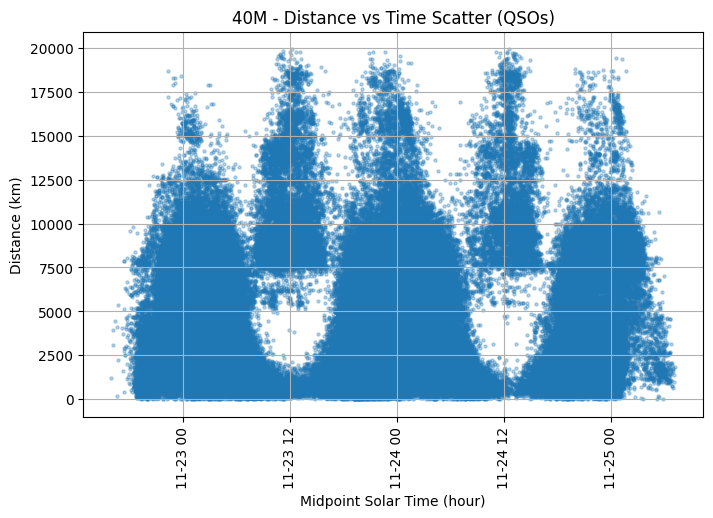

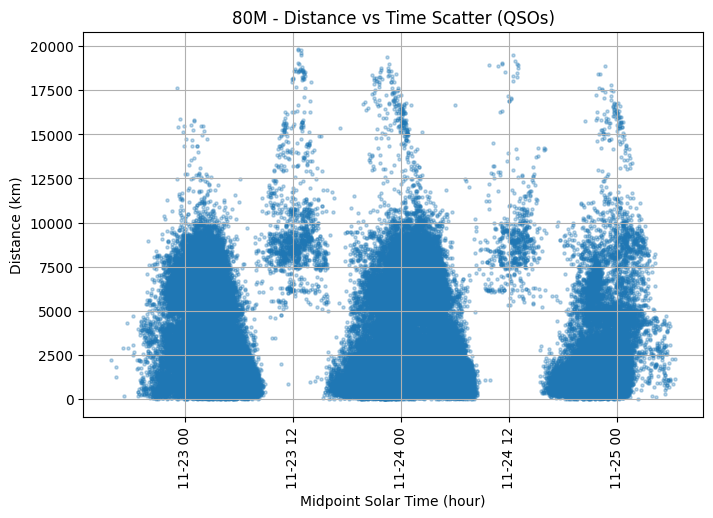

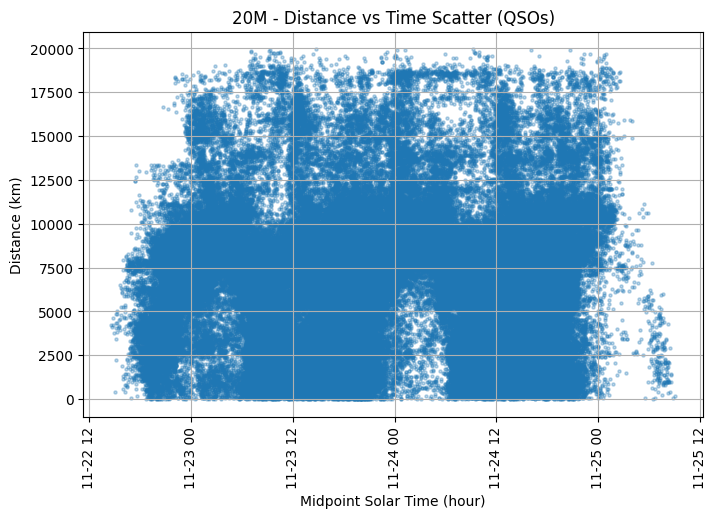

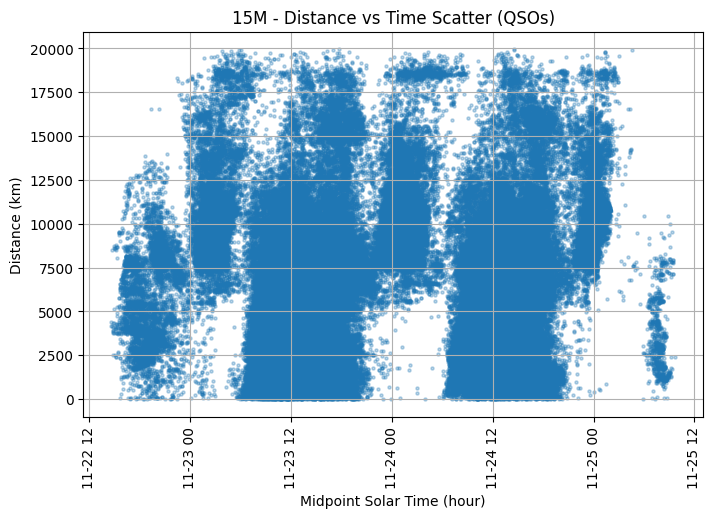

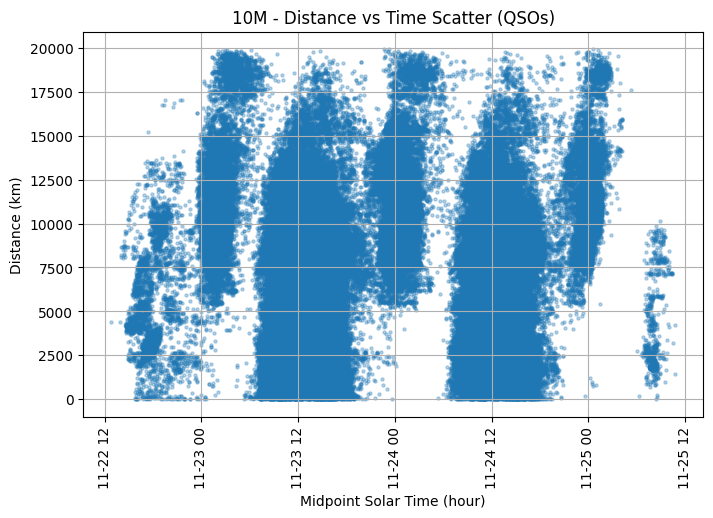

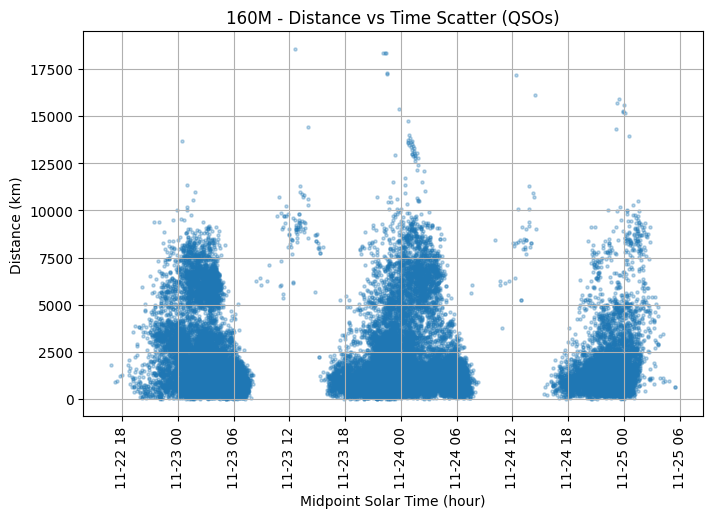

In [86]:
bands = pos['band'].unique()

for band in bands:
    df_band = pos[(pos['band'] == band) & (pos['distance'].notnull()) & (pos['midpoint_solar_time'].notnull())]

    plt.figure(figsize=(8,5))
    plt.scatter(df_band['midpoint_solar_time'], df_band['distance'], alpha=0.3, s=5)
    plt.xticks(rotation=90)
    plt.xlabel('Midpoint Solar Time (hour)')
    plt.ylabel('Distance (km)')
    plt.title(f'{band} - Distance vs Time Scatter (QSOs)')
    plt.grid(True)
    plt.show()

In [87]:
# random sampling 

from random import sample
from xml.etree.ElementInclude import include


bands = pos['band'].unique()

def sample_by_band(df, n_samples = 20000, seed = 42):
    """
    Return a dataframe with up to `n_per_band` rows for every distinct `band`.
    Keeps the sample balanced so each band is equally represented.

    Args:
        df (_type_): _description_
        n_samples (int, optional): _description_. Defaults to 20000.
        seed (int, optional): _description_. Defaults to 42.
    """
    
    rng = np.random.default_rng(seed)
    grouped = df.groupby('band', group_keys=False)
    
    def _sample(group):
        if len(group) > n_samples:
            return group.sample(n=n_samples, random_state=rng)
        else:
            return group
        
    sampled = grouped.apply(_sample)
    return sampled.reset_index(drop=True)

qso_sampled = sample_by_band(pos)

C:\Users\neela\AppData\Local\Temp\ipykernel_21312\2695616116.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = grouped.apply(_sample)


In [88]:
# Implementing Warped epanechnikov kernel

def circular_distance(t, t_i, period = 24.0):
    dt = np.abs(t - t_i)
    dt = np.minimum(dt, period - dt)  # Ensure circular distance
    return dt

def epan(u):
    mask = np.abs(u) <= 1
    out = np.zeros_like(u, dtype=float)
    out[mask] = 0.75 * (1 - u[mask] ** 2)
    return out

def kde2d_warped_epan(time, dist, grid_t, grid_d, h_t, h_d):
    """
    Perform 2D kernel density estimation with warped Epanechnikov kernel.
    
    Parameters:
        time (np.ndarray): Time data.
        dist (np.ndarray): Distance data.
        grid_t (np.ndarray): Grid for time.
        grid_d (np.ndarray): Grid for distance.
        h_t (float): Bandwidth for time.
        h_d (float): Bandwidth for distance.
        
    Returns:
        density: 2D array of estimated densities.
    """
    n = len(time)
    T,D = np.meshgrid(grid_t, grid_d)
    G = np.zeros_like(T, dtype=float)
    
    for t, d in zip(time, dist):
        Kt = epan(circular_distance(T, t)/ h_t) / h_t
        Kd = epan((D - d) / h_d) / h_d
        G += Kt * Kd # product of the kernels
    G /= n  # Normalize by number of points
    density = G
    
    return density

In [89]:
print(qso_sampled.columns)


Index(['sent_call', 'rcvd_call', 'pairs', 'band', 'slice', 'Y', 'CALLSIGN',
       'CATEGORY-POWER', 'CATEGORY-OPERATOR', 'CATEGORY-ASSISTED',
       'CATEGORY-TRANSMITTER', 'GRID-LOCATOR', 'LOG_QSO_COUNT', 'CALLSIGN_RX',
       'CATEGORY-POWER_RX', 'CATEGORY-OPERATOR_RX', 'CATEGORY-ASSISTED_RX',
       'CATEGORY-TRANSMITTER_RX', 'GRID-LOCATOR_RX', 'LOG_QSO_COUNT_RX',
       'distance', 'midpoint_solar_time'],
      dtype='object')


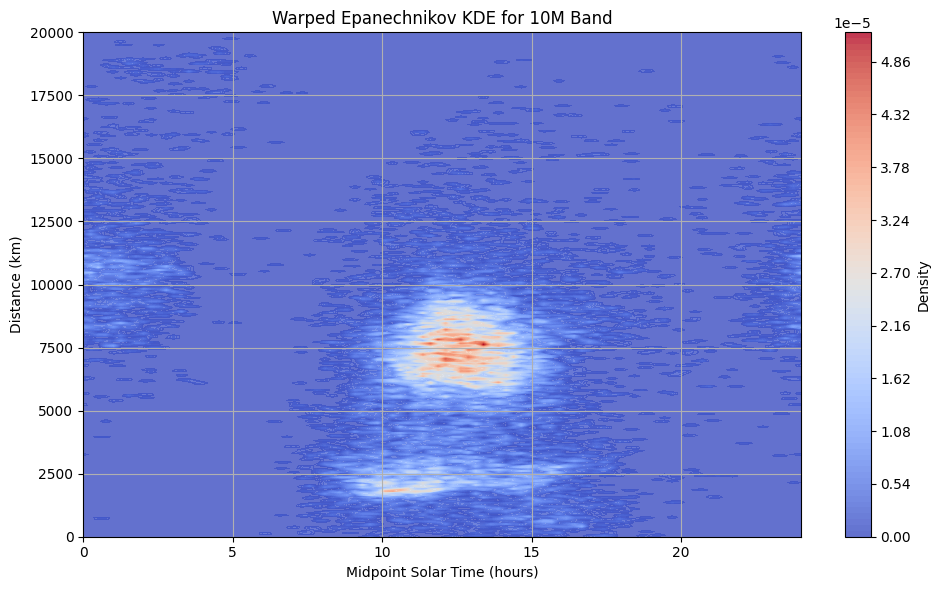

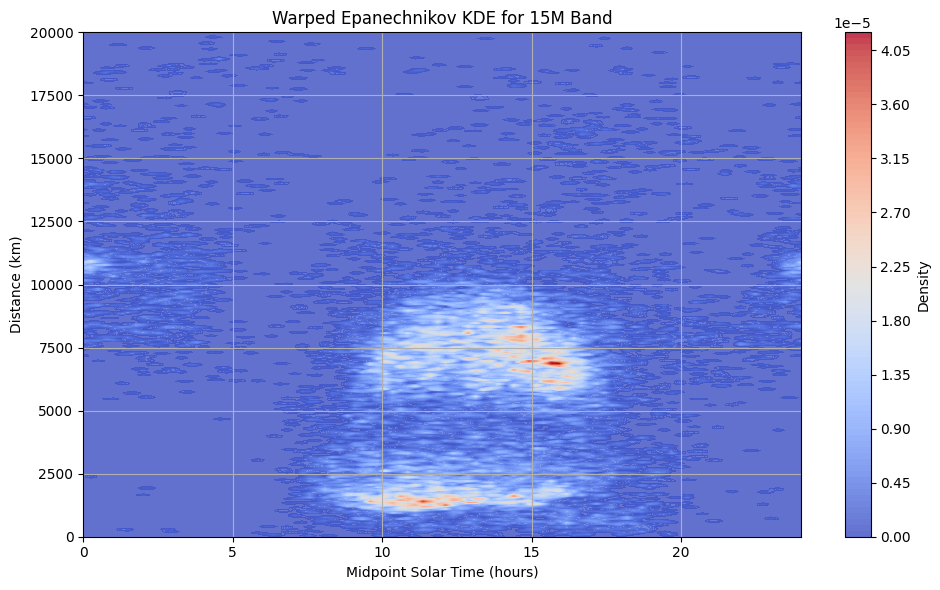

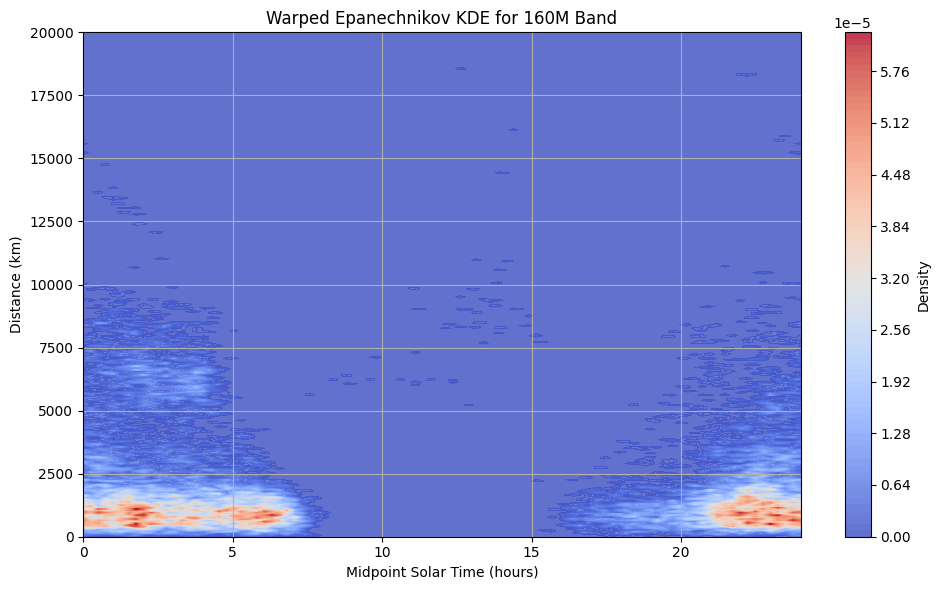

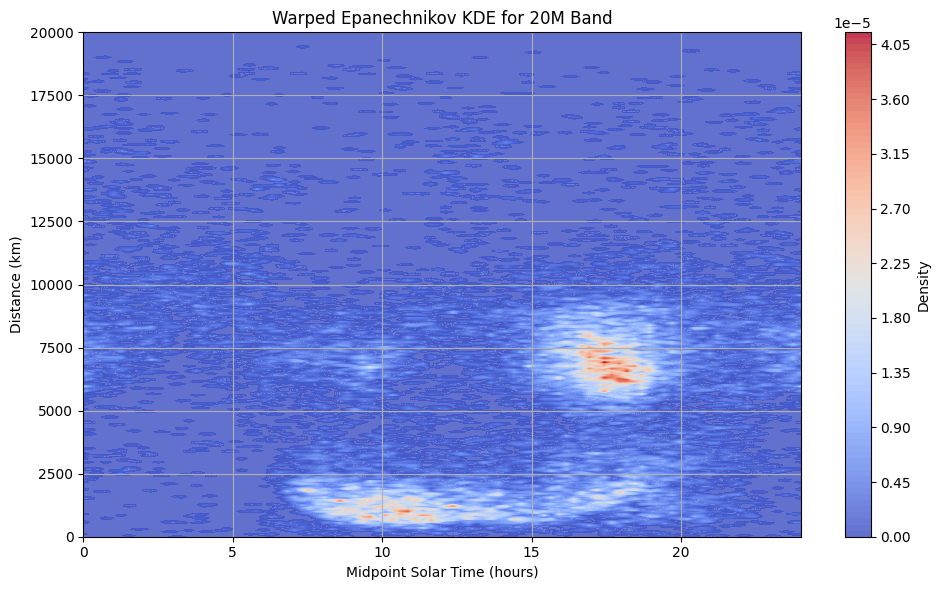

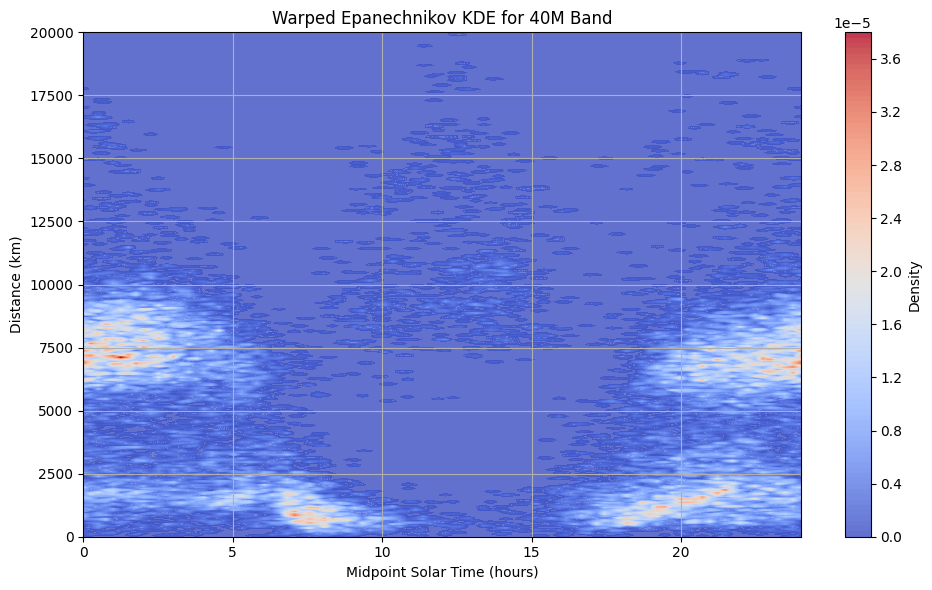

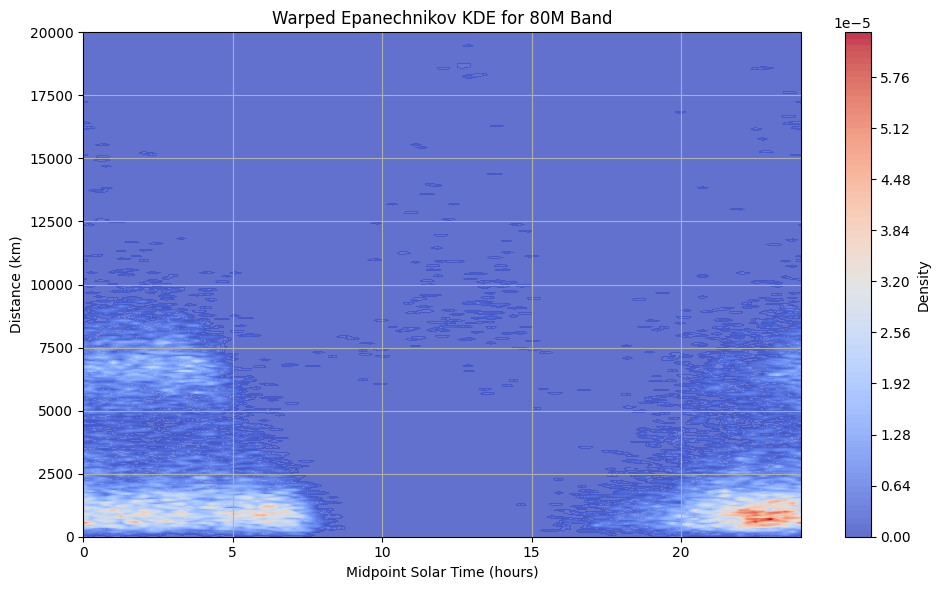

In [90]:

bands = qso_sampled['band'].unique()

for band in bands:
    df = qso_sampled[qso_sampled['band'] == band]

    time_vec = (df['midpoint_solar_time'].dt.hour
            + df['midpoint_solar_time'].dt.minute / 60
            + df['midpoint_solar_time'].dt.second / 3600).to_numpy()

    dist_vec = df['distance'].to_numpy()

    grid_t = np.linspace(0, 24, 96)  # 24 hours
    grid_d = np.linspace(0, 20000, 400)  # Distance in km

    h_t = 0.25  # Bandwidth for time
    h_d = 50  # Bandwidth for distance

    density = kde2d_warped_epan(time_vec, dist_vec, grid_t, grid_d, h_t, h_d)

    T, D = np.meshgrid(grid_t, grid_d)
    plt.figure(figsize=(10, 6))
    pcm = plt.contourf(T, D, density, levels=100, cmap='coolwarm', alpha=0.8)
    plt.xlabel('Midpoint Solar Time (hours)')
    plt.ylabel('Distance (km)')
    plt.title(f'Warped Epanechnikov KDE for {band} Band')
    plt.colorbar(pcm, label='Density')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [91]:
from collections import defaultdict

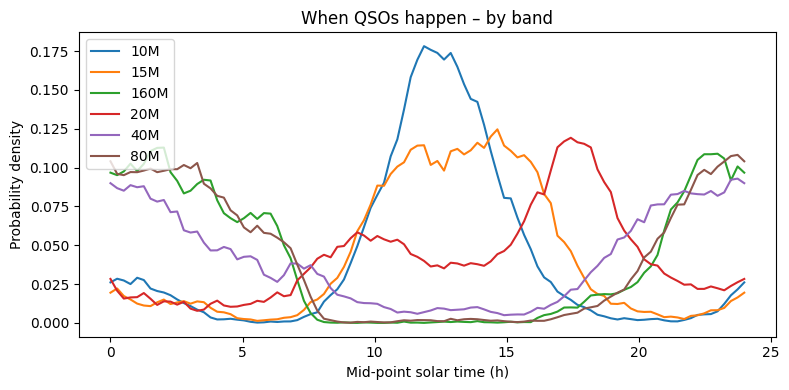

In [92]:
bands = qso_sampled['band'].unique()

Δd = grid_d[1] - grid_d[0]           # 50 km 
Δt = grid_t[1] - grid_t[0]           # 0.25 h (15 min)

prob_time_by_band = {}

for band in bands:
    df = qso_sampled[qso_sampled['band'] == band]

    time_vec = (df['midpoint_solar_time'].dt.hour +
                df['midpoint_solar_time'].dt.minute / 60 +
                df['midpoint_solar_time'].dt.second / 3600).to_numpy()

    dist_vec = df['distance'].to_numpy()

    density = kde2d_warped_epan(time_vec, dist_vec, grid_t, grid_d, h_t, h_d)
    
    p_t = (density.sum(axis=0) * Δd) # Integrate over distance
    p_t /= p_t.sum() * Δt  # Normalize to get probabilities
    
    prob_time_by_band[band] = p_t
    
# Plotting the probabilities for each band
plt.figure(figsize=(8,4))
for band, p_t in prob_time_by_band.items():
    plt.plot(grid_t, p_t, label=band)
plt.xlabel('Mid-point solar time (h)')
plt.ylabel('Probability density')
plt.title('When QSOs happen – by band')
plt.legend()
plt.tight_layout(); plt.show()
  


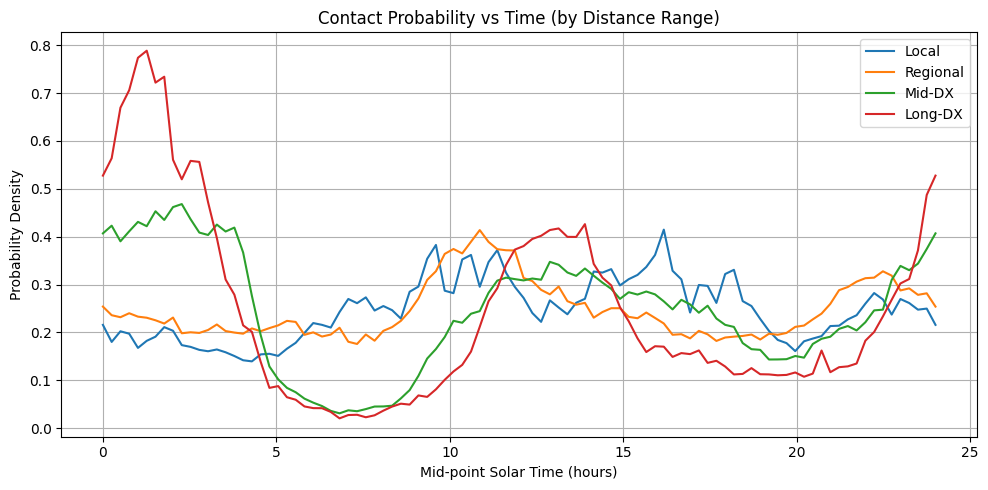

In [93]:
distance_bins = {
    'Local': (0, 1000),
    'Regional': (1000, 4000),
    'Mid-DX': (4000, 8000),
    'Long-DX': (8000, 20000)
}


prob_time_by_range = defaultdict(lambda: np.zeros_like(grid_t))

for band in bands:
    df = qso_sampled[qso_sampled['band'] == band]

    time_vec = (df['midpoint_solar_time'].dt.hour +
                df['midpoint_solar_time'].dt.minute / 60 +
                df['midpoint_solar_time'].dt.second / 3600).to_numpy()

    dist_vec = df['distance'].to_numpy()

    density = kde2d_warped_epan(time_vec, dist_vec, grid_t, grid_d, h_t, h_d)

    for label, (d_lo, d_hi) in distance_bins.items():
        mask = (grid_d >= d_lo) & (grid_d < d_hi)
        p_t = density[mask, :].sum(axis=0) * Δd
        p_t /= p_t.sum() * Δt
        prob_time_by_range[label] += p_t  # sum across bands
        
# Plot contact probability vs time for each distance range
plt.figure(figsize=(10, 5))
for label, p_t in prob_time_by_range.items():
    plt.plot(grid_t, p_t, label=label)
plt.xlabel("Mid-point Solar Time (hours)")
plt.ylabel("Probability Density")
plt.title("Contact Probability vs Time (by Distance Range)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

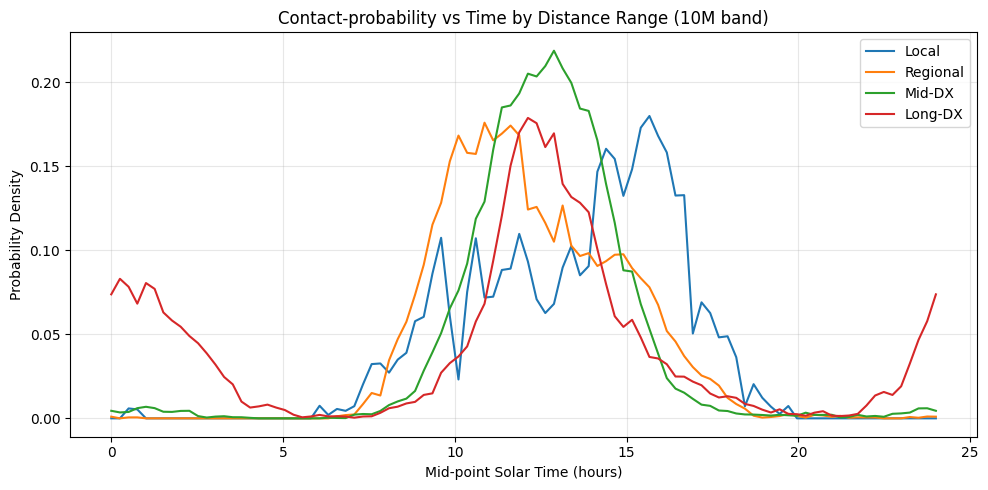

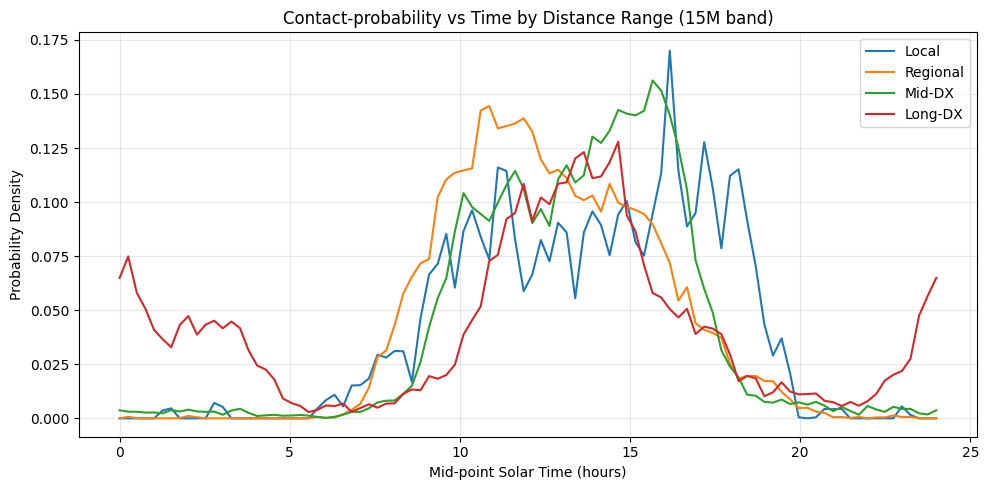

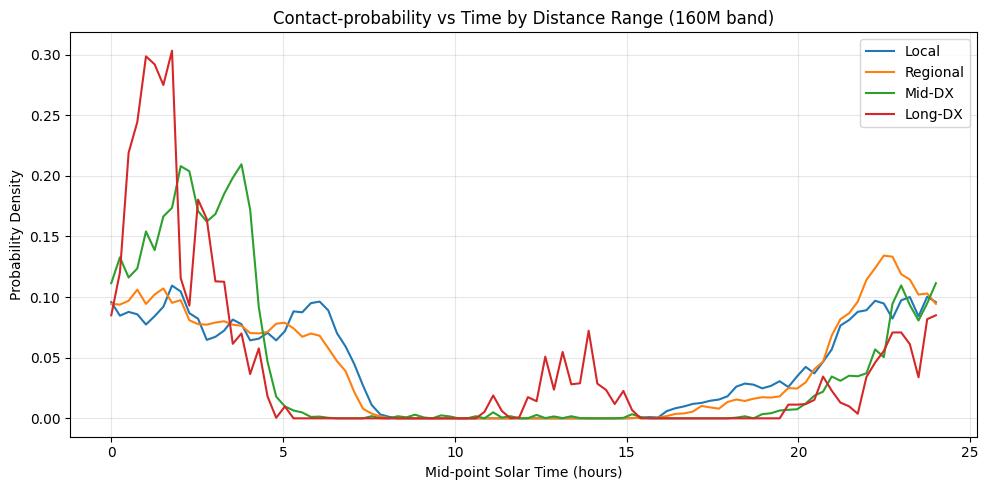

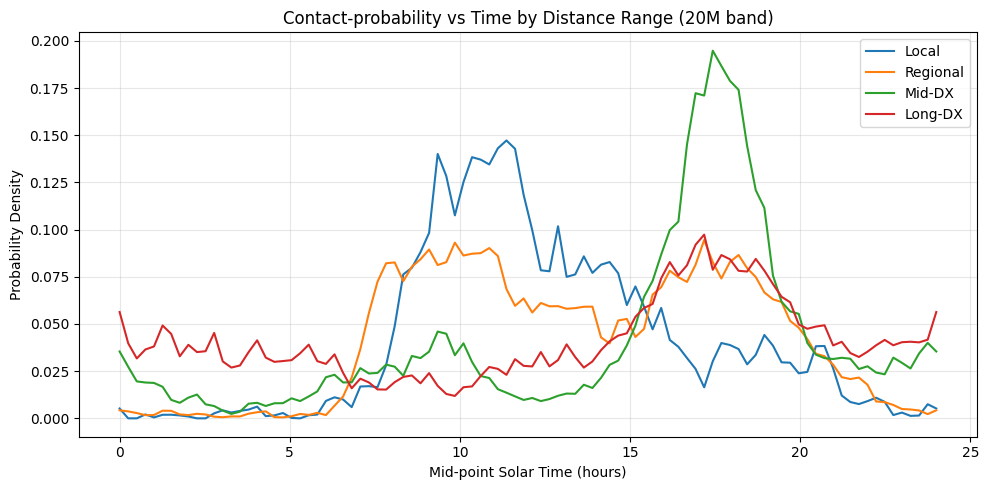

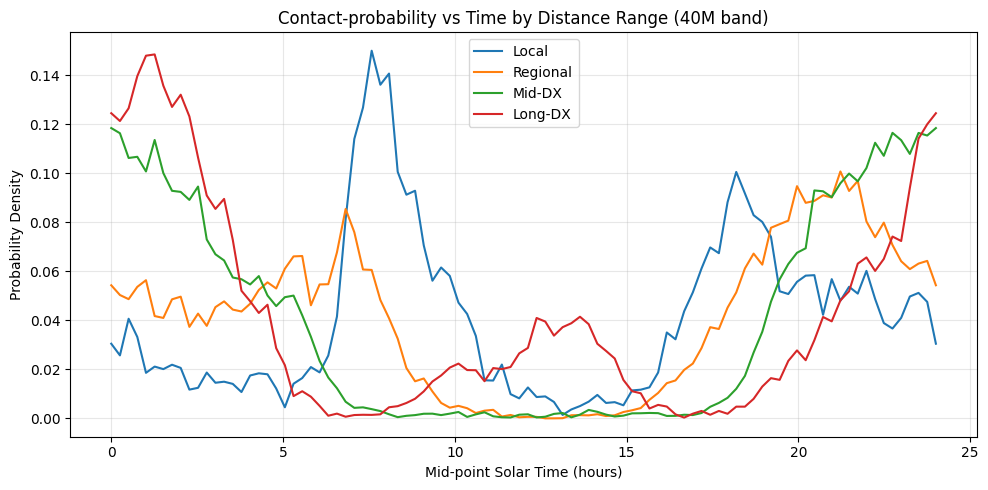

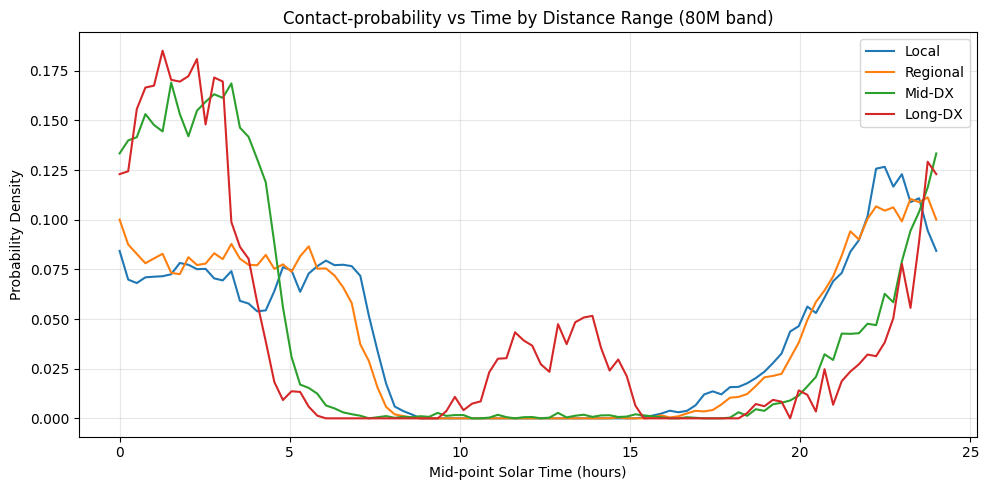

In [94]:
for band in bands:                                   #loop over bands
    df = qso_sampled[qso_sampled['band'] == band]

    time_vec = (df['midpoint_solar_time'].dt.hour +
                df['midpoint_solar_time'].dt.minute / 60 +
                df['midpoint_solar_time'].dt.second / 3600).to_numpy()

    dist_vec = df['distance'].to_numpy()

    
    density = kde2d_warped_epan(time_vec, dist_vec,
                                grid_t, grid_d, h_t, h_d)

   
    plt.figure(figsize=(10, 5))
    for label, (d_lo, d_hi) in distance_bins.items():
        mask = (grid_d >= d_lo) & (grid_d < d_hi)
        p_t  = density[mask, :].sum(axis=0) * Δd      # integrate over distance
        p_t /= p_t.sum() * Δt                         # normalise to area = 1
        plt.plot(grid_t, p_t, label=label)

    plt.xlabel('Mid-point Solar Time (hours)')
    plt.ylabel('Probability Density')
    plt.title(f'Contact-probability vs Time by Distance Range ({band} band)')
    plt.legend()
    plt.grid(True, alpha=.3)
    plt.tight_layout()
    plt.show()

In [98]:
print(pos.columns)  # Display the columns of the pos DataFrame

Index(['sent_call', 'rcvd_call', 'pairs', 'band', 'slice', 'Y', 'CALLSIGN',
       'CATEGORY-POWER', 'CATEGORY-OPERATOR', 'CATEGORY-ASSISTED',
       'CATEGORY-TRANSMITTER', 'GRID-LOCATOR', 'LOG_QSO_COUNT', 'CALLSIGN_RX',
       'CATEGORY-POWER_RX', 'CATEGORY-OPERATOR_RX', 'CATEGORY-ASSISTED_RX',
       'CATEGORY-TRANSMITTER_RX', 'GRID-LOCATOR_RX', 'LOG_QSO_COUNT_RX',
       'distance', 'midpoint_solar_time'],
      dtype='object')


In [ ]:
# possible distances pairs based on band - distrbution of distances
# for every contestant pair (if we fix bands) - distance can be calculated, contact probability can be calculated (based on distance) 

band_of_interest = '40M'

pos_40m = pos[pos['band'] == band_of_interest].copy()

# remove rows with NaN in Grid Locator or Grid Locator RX
pos_40m = pos_40m.dropna(subset=['GRID-LOCATOR', 'GRID-LOCATOR_RX'])

unique_operators_on_40m = pos_40m['sent_call'].unique()

print(f"Number of unique operators on {band_of_interest}: {len(unique_operators_on_40m)}")

# creating all possible pairs of operators on 40m band
from itertools import combinations
from math import dist
operator_pairs = list(combinations(unique_operators_on_40m, 2))

print(f"Number of unique operator pairs on {band_of_interest}: {len(operator_pairs)}")

print(f"First 5 operator pairs on {band_of_interest}: {operator_pairs[:5]}")

distances_of_pairs = []
for op1, op2 in operator_pairs:
    loc1 = pos_40m[pos_40m['sent_call'] == op1]['GRID-LOCATOR'].values[0]
    loc2 = pos_40m[pos_40m['sent_call'] == op2]['GRID-LOCATOR_RX'].values[0]
    
    distance = safe_maidenhead_distance(loc1, loc2)
    distances_of_pairs.append((op1, op2, distance))
    
print(f"First 5 distances of operator pairs on {band_of_interest}: {distances_of_pairs[:5]}")
    

In [106]:
from itertools import combinations

# Get unique operators and their grid locators
ops = pos_40m[['sent_call', 'GRID-LOCATOR']].drop_duplicates().set_index('sent_call')
ops_rx = pos_40m[['sent_call', 'GRID-LOCATOR_RX']].drop_duplicates().set_index('sent_call')

# Create all possible pairs as a DataFrame
operator_pairs_df = pd.DataFrame(list(combinations(ops.index, 2)), columns=['op1', 'op2'])

# Merge locators for both operators
operator_pairs_df = operator_pairs_df.merge(ops, left_on='op1', right_index=True)
operator_pairs_df = operator_pairs_df.merge(ops_rx, left_on='op2', right_index=True, suffixes=('_1', '_2'))

# Vectorized distance calculation
operator_pairs_df['distance'] = operator_pairs_df.apply(
    lambda row: safe_maidenhead_distance(row['GRID-LOCATOR_1'], row['GRID-LOCATOR_RX']), axis=1
)

# Result: operator_pairs_df[['op1', 'op2', 'distance']]
print(operator_pairs_df.head())

KeyboardInterrupt: 

In [112]:
from itertools import combinations

# Get unique operators and their grid locators
ops = pos_40m[['sent_call', 'GRID-LOCATOR']].drop_duplicates().set_index('sent_call')
ops_rx = pos_40m[['sent_call', 'GRID-LOCATOR_RX']].drop_duplicates().set_index('sent_call')

# Create all possible pairs
all_pairs = list(combinations(ops.index, 2))
print(f"Total number of operator pairs: {len(all_pairs)}")
# Sample a subset of pairs (e.g., 5000 pairs)
import numpy as np
np.random.seed(42)
sample_size = min(100000, len(all_pairs))
sampled_pairs = np.random.choice(len(all_pairs), sample_size, replace=False)
sampled_pairs = [all_pairs[i] for i in sampled_pairs]

# Create DataFrame from sampled pairs
operator_pairs_df = pd.DataFrame(sampled_pairs, columns=['op1', 'op2'])

# Merge locators for both operators
operator_pairs_df = operator_pairs_df.merge(ops, left_on='op1', right_index=True)
operator_pairs_df = operator_pairs_df.merge(ops_rx, left_on='op2', right_index=True, suffixes=('_1', '_2'))

# Vectorized distance calculation
operator_pairs_df['distance'] = operator_pairs_df.apply(
    lambda row: safe_maidenhead_distance(row['GRID-LOCATOR'], row['GRID-LOCATOR_RX']), axis=1
)

print(operator_pairs_df.head())

Total number of operator pairs: 10226503
    op1    op2 GRID-LOCATOR GRID-LOCATOR_RX      distance
0  K3SV  LZ1ZJ       EL88VH          LO22OX   9646.801651
0  K3SV  LZ1ZJ       EL88VH          LO44WI   9742.705191
0  K3SV  LZ1ZJ       EL88VH          JO21PF   7428.655025
0  K3SV  LZ1ZJ       EL88VH          NO35FL  10635.579132
0  K3SV  LZ1ZJ       EL88VH          FM18HQ   1237.113528


In [ ]:
# add a column in operator_pairs_df to check if the pair makes contact (refer to pos_40m) - boolean column 0 or 1 (for contact made)
# Create a set of all contacted pairs (unordered)
contacted_pairs = set(
    
    
    tuple(sorted(pair)) for pair in pos_40m['pairs'].values)

# Add contact_made column: 1 if pair made contact, else 0
operator_pairs_df['contact_made'] = operator_pairs_df.apply(
    lambda row: 1 if tuple(sorted([row['op1'], row['op2']])) in contacted_pairs else 0,
    axis=1
)


In [116]:
print(operator_pairs_df[operator_pairs_df['contact_made'] == 1].head())

       op1   op2 GRID-LOCATOR GRID-LOCATOR_RX     distance  contact_made
32  JE2GUV  W7RM       PM85ig          LO44WI  6704.520008             1
32  JE2GUV  W7RM       PM85ig          KN03JR  9104.282143             1
32  JE2GUV  W7RM       PM85ig          KN27QG  8577.138697             1
32  JE2GUV  W7RM       PM85ig          KN04PF  9037.365586             1
32  JE2GUV  W7RM       PM85ig          KN44HD  8592.192081             1
